### 📊 Descripción de los datos

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

#### 💾 Carga de Data Set

In [2]:
train_df = pd.read_parquet('../data/processed/train_dataset.parquet', engine='pyarrow')
train_df.sort_values(by="Fecha HR", inplace=True)
test_df  = pd.read_parquet('../data/processed/test_dataset.parquet', engine='pyarrow')
test_df.sort_values(by="Fecha HR", inplace=True)

### 🤖 Generación de modelo

Dado que se observan comportamientos diferentes entre clientes, se generaran series temporales por cada cliente, para esto es necesario dividir dadaset, por dataset para cada cliente

##### ✂️ Dividimos dataset de entrenamiento por cada cliente

In [20]:
# Crear un diccionario para almacenar los datos por cliente
train_data_by_client = {}

# Obtener los clientes únicos
clients = train_df['CLIENTE'].unique()

# Iterar sobre cada cliente y almacenar los datos correspondientes en el diccionario
for client in clients:
    train_data_by_client[client] = train_df[train_df['CLIENTE'] == client].reset_index(drop=True)
    train_data_by_client[client] = train_data_by_client[client].drop('CLIENTE', axis=1)
    # Se crea campo de fecha en formato Tiempo Unix, para facilidad en creacion de regecion polinomica.
    train_data_by_client[client]['date_int'] = np.array([fecha.timestamp() for fecha in train_data_by_client[client]['Fecha HR']])


# Verificar los datos por cliente
for client, data in train_data_by_client.items():
    print(f"Cliente: {client}, Número de registros: {data.shape[0]}")

Cliente: C-2, Número de registros: 90948
Cliente: C-4, Número de registros: 90948
Cliente: C-3, Número de registros: 90948
Cliente: C-5, Número de registros: 90948
Cliente: C-R, Número de registros: 91235


In [17]:
# Crear un diccionario para almacenar los datos por cliente
test_data_by_client = {}

# Obtener los clientes únicos
clients = test_df['CLIENTE'].unique()

# Iterar sobre cada cliente y almacenar los datos correspondientes en el diccionario
for client in clients:
    test_data_by_client[client] = test_df[test_df['CLIENTE'] == client].reset_index(drop=True)
    test_data_by_client[client] = test_data_by_client[client].drop('CLIENTE', axis=1)
    # Se crea campo de fecha en formato Tiempo Unix, para facilidad en creacion de regecion polinomica.
    test_data_by_client[client]['date_int'] = np.array([fecha.timestamp() for fecha in test_data_by_client[client]['Fecha HR']])

# Verificar los datos por cliente
for client, data in test_data_by_client.items():
    print(f"Cliente: {client}, Número de registros: {data.shape[0]}")

Cliente: C-2, Número de registros: 22812
Cliente: C-3, Número de registros: 22812
Cliente: C-4, Número de registros: 22812
Cliente: C-5, Número de registros: 22812
Cliente: C-R, Número de registros: 22812


##### 🕺🤖 Generacion de modelos por cada cliente

In [48]:
# Ajustar modelos Prophet para cada cliente
models = {}
for client, data in train_data_by_client.items():
    models[client] = {}
    # se crearan modelos con diferentes grados para verificar con cual grado de polinomio se obtiene un mejor resultado
    for i in range(1,31):
        coef = np.polyfit(data['date_int'], data['kWh E'], i)
        # Almacenar el modelo ajustado en el diccionario de modelos
        models[client][i] = coef

/tmp/ipykernel_11179/2856342408.py:7: RankWarning: Polyfit may be poorly conditioned
  coef = np.polyfit(data['date_int'], data['kWh E'], i)
/tmp/ipykernel_11179/2856342408.py:7: RankWarning: Polyfit may be poorly conditioned
  coef = np.polyfit(data['date_int'], data['kWh E'], i)
/tmp/ipykernel_11179/2856342408.py:7: RankWarning: Polyfit may be poorly conditioned
  coef = np.polyfit(data['date_int'], data['kWh E'], i)
/tmp/ipykernel_11179/2856342408.py:7: RankWarning: Polyfit may be poorly conditioned
  coef = np.polyfit(data['date_int'], data['kWh E'], i)
/tmp/ipykernel_11179/2856342408.py:7: RankWarning: Polyfit may be poorly conditioned
  coef = np.polyfit(data['date_int'], data['kWh E'], i)
/tmp/ipykernel_11179/2856342408.py:7: RankWarning: Polyfit may be poorly conditioned
  coef = np.polyfit(data['date_int'], data['kWh E'], i)
/tmp/ipykernel_11179/2856342408.py:7: RankWarning: Polyfit may be poorly conditioned
  coef = np.polyfit(data['date_int'], data['kWh E'], i)
/tmp/ipykerne

##### 🛠️ Test modelo

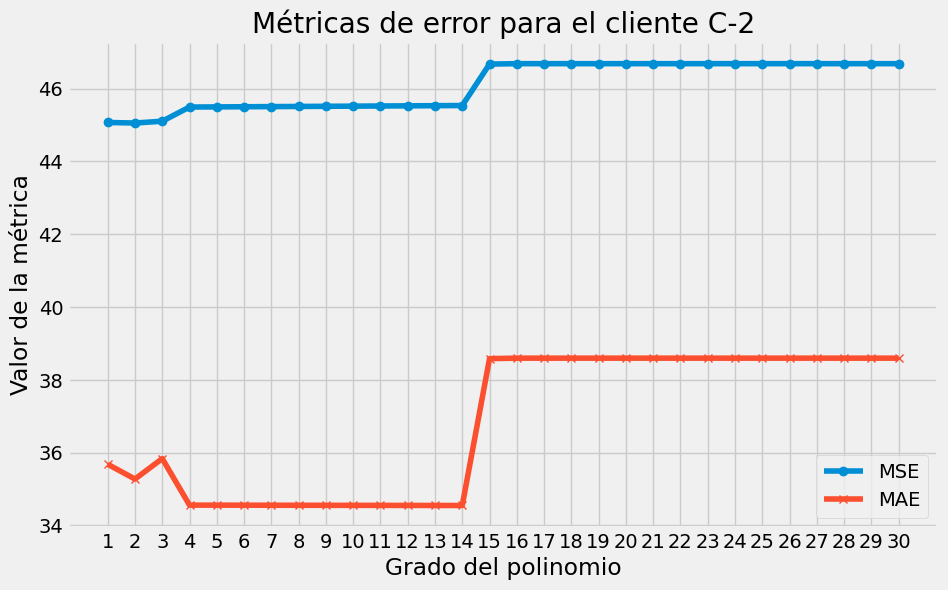

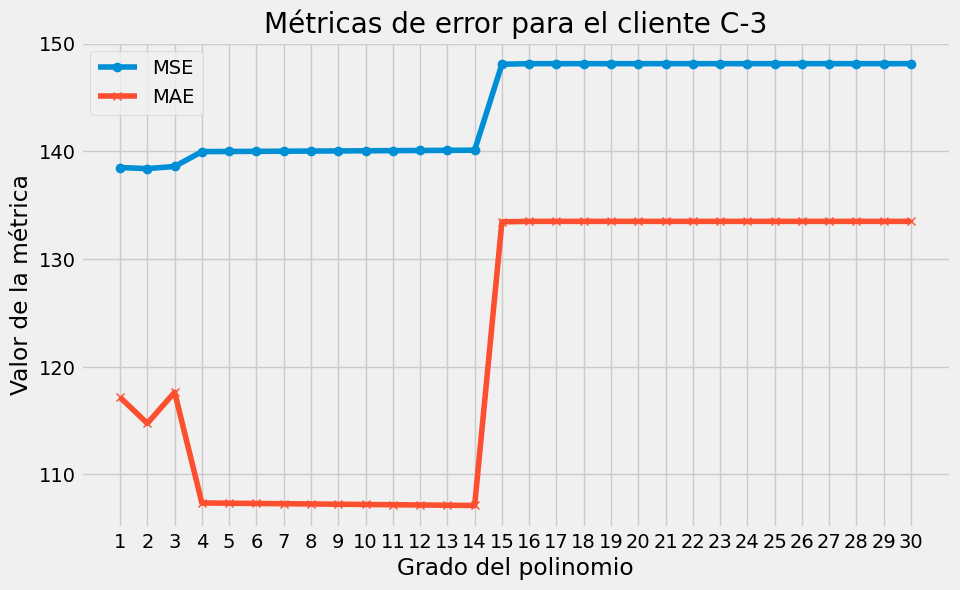

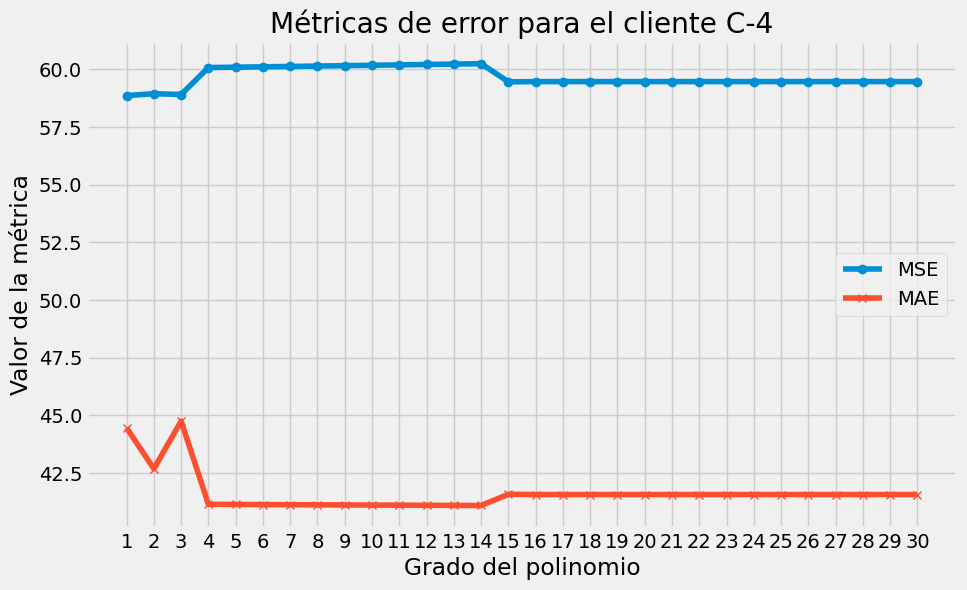

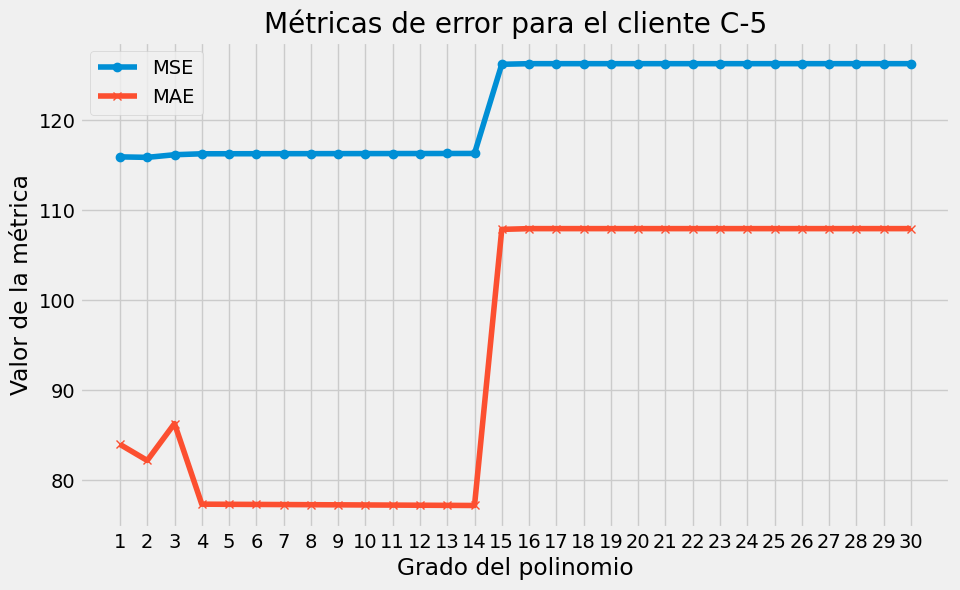

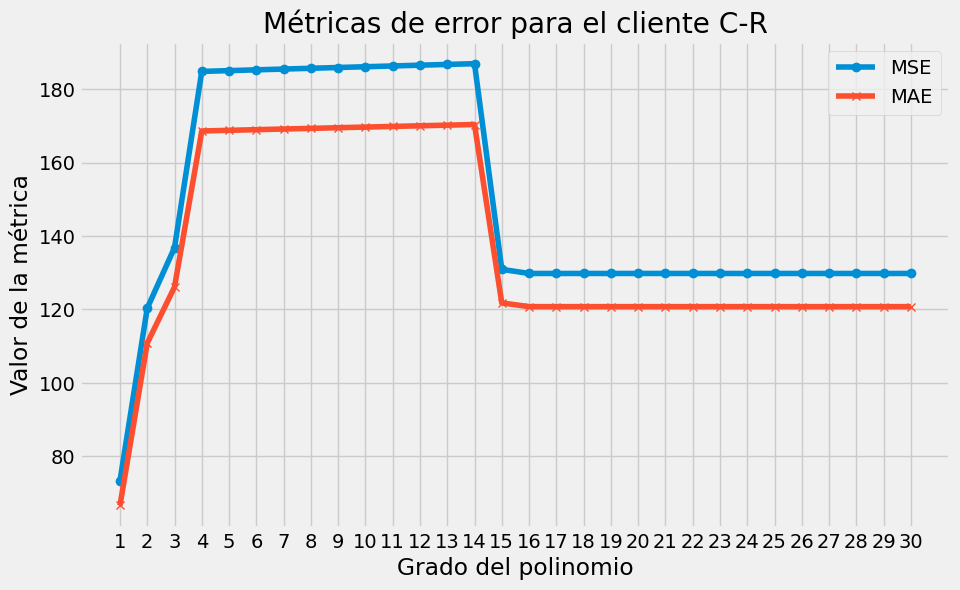

In [49]:
for client, data in test_data_by_client.items():
    MSE = []
    MAE = []
    MAPE = []
    for model, coefs in models[client].items():
        predict = np.polyval(coefs, data['date_int'])
        MSE.append( np.sqrt(mean_squared_error(y_true=data['kWh E'],
                    y_pred=predict))
        )
        MAE.append(mean_absolute_error(y_true=data['kWh E'],
                    y_pred=predict)
                )
        MAPE.append(mean_absolute_percentage_error(y_true=data['kWh E'],
                    y_pred=predict)
                )
    
    grados = list(models[client].keys())
    
    plt.figure(figsize=(10, 6))
    
    plt.plot(grados, MSE, marker='o', label='MSE')
    plt.plot(grados, MAE, marker='x', label='MAE')
    # plt.plot(grados, MAPE, marker='s', label='MAPE')
    
    plt.title(f'Métricas de error para el cliente {client}')
    plt.xlabel('Grado del polinomio')
    plt.ylabel('Valor de la métrica')
    plt.xticks(grados)
    plt.legend()
    plt.grid(True)